# GRU with "Batch Generator"

In [2]:
# reset variables
%reset -f

# import external modules
import sys, os
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc 
from datetime import datetime
from tabulate import tabulate
from decimal import Decimal

import keras
print("keras.__version__ =", keras.__version__ )
from keras import layers, regularizers, Input, Model
from keras.optimizers import RMSprop, Adam, Nadam
from keras.initializers import RandomUniform
from keras.models import Sequential
from keras import backend as K

import tensorflow as tf
tf.set_random_seed(100)
print("tf.__version__ =", tf.__version__)
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from functions import MAE, RMSE, split_dataset

keras.__version__ = 2.2.4
tf.__version__ = 1.12.0


In [3]:
# Set global paths
ROOT_PATH = os.path.abspath(".").split("src")[0]

# configure matplotlib params and plotting
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

rc('figure', figsize=(12,6))
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=13, titlesize=14)
rc('legend', fontsize=14, handlelength=2)
rc('font', family='serif')

SEED=100
np.random.seed(SEED)

## 2. Data loading
<hr> 
Load data from pre-stored files

In [4]:
path = ROOT_PATH + "data/dataframes/"
df_train = pd.read_pickle(path + "df_scaled_train.pkl")
df_valid = pd.read_pickle(path + "df_scaled_valid.pkl")
df_test = pd.read_pickle(path + "df_scaled_test.pkl")

USE_DUMMY_DATA = True
if USE_DUMMY_DATA: 
    num_obs = 10000  # 5000, 10000 or 25000
    path = ROOT_PATH + "data/dummy/"
    df_train = pd.read_pickle(path + "dummy_train_{0}.pkl".format(num_obs))
    df_valid = pd.read_pickle(path + "dummy_valid_{0}.pkl".format(num_obs))
    df_test = pd.read_pickle(path + "dummy_test_{0}.pkl".format(num_obs))

# splitting into training, testing and validation sets
x_train, y_train = split_dataset(df_train.values, delay=1)
x_valid, y_valid = split_dataset(df_valid.values, delay=1)
x_test, y_test = split_dataset(df_test.values, delay=1)

# reading metadata
path = ROOT_PATH + "data/metadata/"

# stats for scaling
stats = pd.read_csv(path+"stats.csv", sep=",")

# tags
headers = df_train.columns.values
target_tags = headers[:3]
feature_tags = headers[3:]

print(df_train.shape, df_valid.shape, df_test.shape)
print(x_train.shape, y_train.shape)

(6000, 21) (2000, 21) (2000, 21)
(5999, 18) (5999, 3)


<hr>

## 3. Defining a Generator

<hr/>
Define a generator to generate batches of data such that the models don't have to read everything at once. 

### Definition

In [5]:
def batch_generator(x_data, y_data, lookback, batch_size=128):
    """
    Generator function for creating random batches of training-data.
    
    :param x_data: Numpy array of the features, not targets. 2D array, normalized/scaled, numpy.
    :param y_data: Numpy array of the targets, not features. 2D array, normalized/scaled, numpy. 
    :param lookback: How many timesteps back the input data should go.
    :param batch_size: The number of samples per batch.
    """
    num_x_signals = x_data.shape[1]
    num_y_signals = y_data.shape[1]

    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, lookback, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, lookback, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(x_data.shape[0] - lookback)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_data[idx:idx+lookback]
            y_batch[i] = y_data[idx:idx+lookback]
        
        yield (x_batch, y_batch)

In [7]:
train_gen = batch_generator(x_train, y_train, lookback=200, batch_size=128)
samples,targets=next(train_gen)
print(samples.shape, targets.shape)

(128, 200, 18) (128, 200, 3)


## 4. Model implementation
---

In [8]:
def plot_history(history, savepath=None):
    """
    Plots the training and validation loss history of the model in the training phase. 
    """
    epochs = history.epoch

    train_mae = history.history['loss']
    val_mae = history.history['val_loss']

    plt.figure()
    plt.plot(epochs, train_mae, marker='o', markersize='3.0', label=r'Training loss', color="darkred")
    plt.plot(epochs, val_mae, marker='o', markersize='3.0', label=r'Validation loss', color="darkblue")  
    plt.xlabel(r'Epoch')
    plt.ylabel(r'MAE')
    plt.legend(frameon=True)
    if savepath is not None: 
        plt.savefig(savepath)
    plt.show()

In [9]:
def build_model(input_layer, num_output_signals):  
    layer_1 = layers.GRU(128,
                         dropout = 0.2,
                         recurrent_dropout = 0.2,
                         return_sequences=True,
                         kernel_initializer = 'glorot_normal')(input_layer)
    
    init = RandomUniform(minval=-0.05, maxval=0.05)
    output_layer = layers.Dense(num_output_signals, kernel_initializer=init)(layer_1)
    
    model = Model(input_layer, output_layer) 
    return model

In [10]:
# Defining variables 
batch_size=128
lookback=200
epochs=10


# train the model
train_gen = batch_generator(x_train, y_train, lookback, batch_size)
valid_gen = batch_generator(x_valid, y_valid, lookback, batch_size)

train_steps = (len(x_train) - lookback) // batch_size
valid_steps = (len(x_valid) - lookback) // batch_size

# Train the model
K.clear_session()
input_layer = Input(shape=(None,x_train.shape[-1]))
model = build_model(input_layer, y_train.shape[-1])
model.compile(loss='MAE', optimizer='ADAM')
model.summary()

history = model.fit_generator(generator=train_gen,
                              epochs=epochs,
                              steps_per_epoch=train_steps,
                              validation_data=valid_gen,
                              validation_steps=valid_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 18)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, None, 128)         56448     
_________________________________________________________________
dense_1 (Dense)              (None, None, 3)           387       
Total params: 56,835
Trainable params: 56,835
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
45/45 [==============================] - 8s 179ms/step - loss: 0.5633 - val_loss: 0.6210
Epoch 2/10
45/45 [==============================] - 8s 171ms/step - loss: 0.4680 - val_loss: 0.6160
Epoch 3/10
45/45 [==============================] - 8s 174ms/step - loss: 0.4494 - val_loss: 0.6188
Epoch 4/10
45/45 [==============================] - 8s 174ms/step - loss: 0.4344 - val_loss: 0.6050
Ep

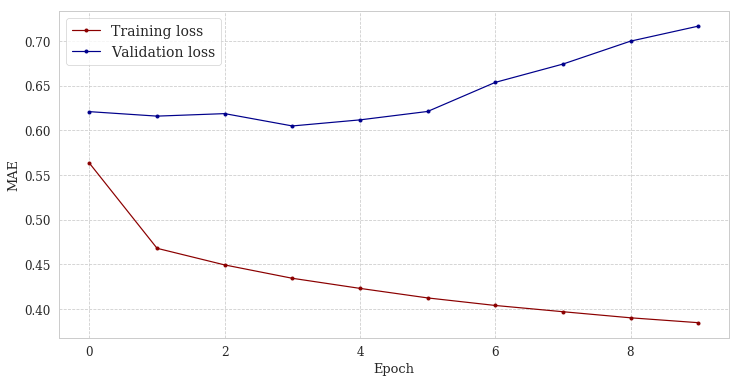

In [11]:
plot_history(history)

## 5. Results

In [12]:
def make_prediction(model, x_data, y_data):
    
    # expand inputs to right dimension
    x = x_data
    if len(x_data.shape) == 1:
        x = np.expand_dims(x_data, axis=0)
    x = np.expand_dims(x,axis=0)
    
    # make predictions
    preds = model.predict(x)[0]
    true = y_data
    
    if len(true.shape) == 1:
        true = np.expand_dims(y_data,axis=0)
    
    return true, preds

def plot_prediction(model, x_data, y_data, plot_from, plot_length):
    plot_to = plot_from + plot_length
    
    true, preds = make_prediction(model, x_data, y_data)
    
    for feature in range(y_data.shape[-1]):
        plt.figure()
        plt.title(feature_tags[feature])
        plt.plot(true[plot_from:plot_to,feature], c="darkred", label="true")
        plt.plot(preds[plot_from:plot_to,feature], c="darkblue", label="predictions")
        plt.legend(frameon=True)
        plt.show()
        
def evaluate_model(model, x_data, y_data):
    true, preds = make_prediction(model, x_data, y_data)
    return MAE(true, preds, vector=True)
    

MAE = [1.07689802 0.40729775 0.69247053]


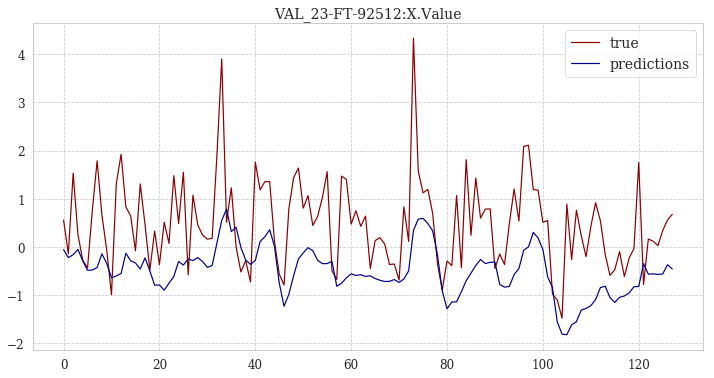

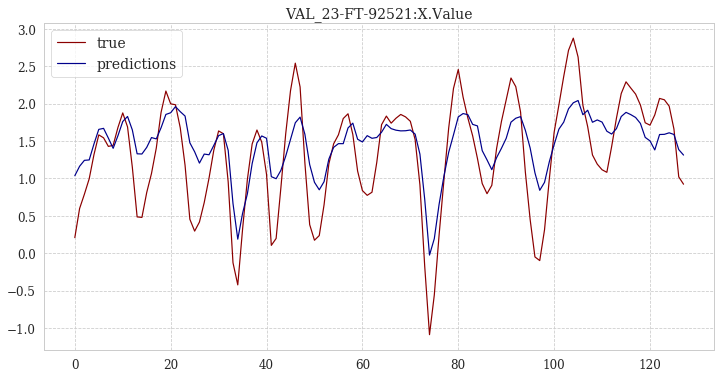

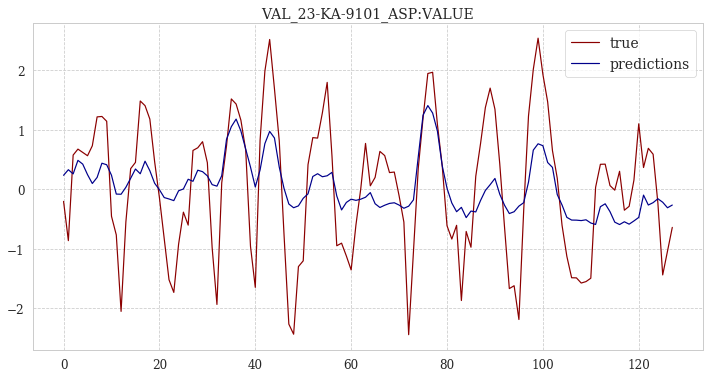

In [13]:
print("MAE = {0}".format(evaluate_model(model, x_valid, y_valid)))
plot_prediction(model, x_valid, y_valid, 0+lookback, 128)